# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт и ознакомление с данными

In [1]:
# выполняем необходимые импорты

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from pymystem3 import Mystem

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# библиотека для обработки слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data = pd.read_csv('/datasets/toxic_comments.csv') # сохраняем датасет в переменной data
data.head() # выводим на экран первые строчки для ознакомления

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.info() # смотрим на данные более подробно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Итак, мы имеем:
* Датасет с тремя столбцами, первый из который дублирует индекс;
* Почти 160 000 строк;
* Типы данных установлены верно;
* Пропусков нет.

### Предобработка

In [6]:
# %%time

# m = Mystem()

# # фунция для лемматизации и очистки текста
# def lemmatize_text(text):
#     text = text.lower()
#     lemm_text = "".join(m.lemmatize(text))
#     cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
#     return ' '.join(cleared_text.split())

# # применяем функцию и заменяем стобец text на обработанный
# data['lemm_text'] = data['text'].apply(lemmatize_text)
# data = data.drop(['text'], axis=1)

In [7]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
%%time

wnl = WordNetLemmatizer()

# фунция для лемматизации и очистки текста
def lemmatize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = text.split()
    lemm_text = []
    for i in range(len(clear_text)):
        lemm_text.append(wnl.lemmatize(clear_text[i], get_wordnet_pos(clear_text[i])))
    return ' '.join(lemm_text)

# применяем функцию и заменяем стобец text на обработанный
data['lemm_text'] = data['text'].apply(lemmatize_text)
# data = data.drop(['text'], axis=1)

CPU times: user 17min 33s, sys: 1min 44s, total: 19min 17s
Wall time: 19min 18s


In [9]:
data['lemm_text'][3] # проверяем

'more i can t make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it s list in the relevant form eg wikipedia good article nomination transport'

In [10]:
data['text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [11]:
data = data.drop(['text'], axis=1)

In [12]:
# создаем переменные с признаками и целевым признаком
target = data['toxic']
features = data.drop(['toxic'], axis=1)

# производим деление на три выборки - тренировочную (40%), валидационную (20%) и тестовую (20%)
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12345)

# создадим счётчик, указав в нём стоп-слова
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

# переводим переменные в формат юникода
# features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values.astype('U'))
# features_valid = count_tf_idf.transform(features_valid['lemm_text'].values.astype('U'))
# features_test = count_tf_idf.transform(features_test['lemm_text'].values.astype('U'))

features_train = count_tf_idf.fit_transform(features_train['lemm_text'])
features_valid = count_tf_idf.transform(features_valid['lemm_text'])
features_test = count_tf_idf.transform(features_test['lemm_text'])

# проверяем
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(95575, 111013)
(31858, 111013)
(31859, 111013)


In [13]:
%%time

# сохраняем модель линейной регрессии в переменную
model_LR = LogisticRegression()

# выполняем перекрестную проверку
train_f1 = cross_val_score(model_LR, 
                      features_train, 
                      target_train, 
                      cv=3, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.6862141964439274
CPU times: user 40.6 s, sys: 1min, total: 1min 41s
Wall time: 1min 41s


Значение F1-меры не дотягивает до необходимой нам величины. Чтобы повысить ее показатели, посмотрим на соотношение классов в нашем датасете.

### Соотношение классов

In [14]:
display(data['toxic'].value_counts())
display(data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1])

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

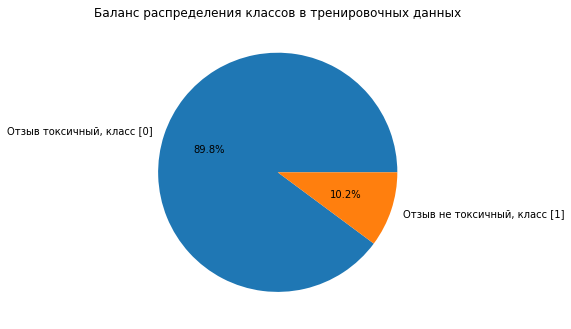

In [15]:
target.value_counts(normalize=True).plot(kind='pie',
                                         figsize=[5.5,5.5],
                                         legend=False,
                                         autopct='%1.1f%%',
                                         labels=['Отзыв токсичный, класс [0]', 'Отзыв не токсичный, класс [1]'])

plt.title('Баланс распределения классов в тренировочных данных')
plt.ylabel('')
plt.show()

Классы оказались крайне несбалансированными, распределившись в соотношении 1 к 8.
Для устранения данной проблемы необходимо сдвинуть весы и уменьшить нулевой класс.

In [16]:
%%time

# изменение весов
model_LR = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(model_LR, 
                                    features_train, 
                                    target_train, 
                                    cv=3, 
                                    scoring='f1').mean()
print('F1:', train_f1_balanced)

F1: 0.7392553882621958
CPU times: user 26.6 s, sys: 38 s, total: 1min 4s
Wall time: 1min 4s


Теперь уравняем количество строк класса 0 и класса 1

In [17]:
# делим классы и создаем для каждого свою переменную
comments_train = data.iloc[target_train.index]

target_train_zero = comments_train[comments_train['toxic'] == 0]['toxic']
target_train_one = comments_train[comments_train['toxic'] == 1]['toxic']

In [21]:
target_train_zero_downsample = target_train_zero.sample(target_train_one.shape[0], random_state=12345)
target_train_downsample = pd.concat([target_train_zero_downsample, target_train_one])

features_train_downsample = data.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample, # перемешиваем
                                                             target_train_downsample,
                                                             random_state=12345)

# кодируем под тип юникода
# features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
#                                                    .values.astype('U'))
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text'])

In [22]:
model_LR = LogisticRegression()
train_f1_downsampled = cross_val_score(model_LR,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=3, 
                      scoring='f1').mean()
print('F1:', train_f1_downsampled)

F1: 0.8822452331370351


F1-мера заметно изменила свое значение в хорошую сторону.

Теперь посмотрим вероятность классов, построим ROC-кривую и на основе полученных данных составим небольшую сводную таблицу с результатами, чтобы можно было наглядно оценить проделанную работу.

### Построение ROC-кривой

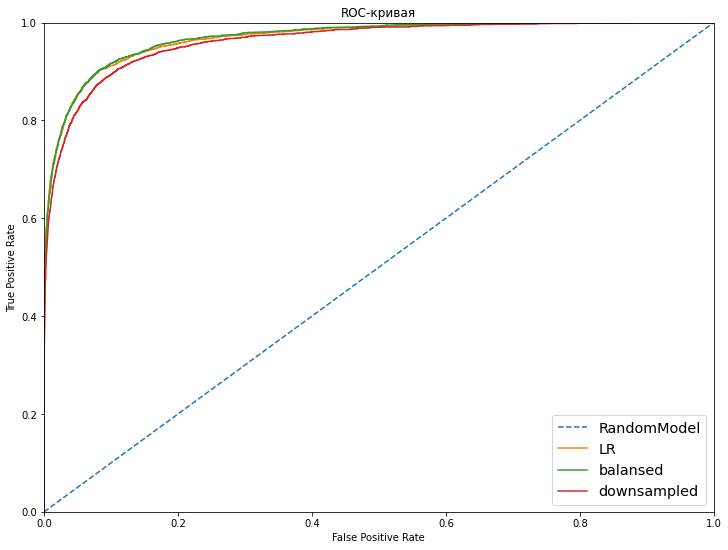

In [23]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model_LR = LogisticRegression()
model_LR.fit(features_train, target_train)
probabilities_valid = model_LR.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, model_LR.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

model_LR = LogisticRegression(class_weight='balanced')
model_LR.fit(features_train, target_train)
probabilities_valid = model_LR.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, model_LR.predict(features_valid))
plt.plot(fpr, tpr, label='balansed')

model_LR = LogisticRegression()
model_LR.fit(features_train_downsample,target_train_downsample)
probabilities_valid = model_LR.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, model_LR.predict(features_valid))
plt.plot(fpr, tpr, label='downsampled')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [24]:
# создаем сводную таблицу с результатами преобразований
index = ['LogisticRegression',
         'balansed',
         'downsampled']
data = {'F1 на CV':[train_f1,
                    train_f1_balanced,
                    train_f1_downsampled],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_downsampled],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced,
                   auc_roc_downsampled]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на валидации,AUC-ROC
LogisticRegression,0.686214,0.732400,0.968181
balansed,0.739255,0.744969,0.969344
downsampled,0.882245,0.692747,0.961708


## Обучение

### Логистическая регрессия

In [25]:
%%time

dict_classes = {0:1, 1:8.4}

model_LR = LogisticRegression()
params = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]

clf = GridSearchCV(model_LR, params, scoring='f1', cv=3)
clf.fit(features_train, target_train)
print('Лучшие параметры:')
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print('Grid scores')
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

Лучшие параметры:

{'C': 10, 'class_weight': {0: 1, 1: 8.4}, 'solver': 'lbfgs'}

Grid scores

0.713196 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.4}, 'solver': 'newton-cg'}
0.713130 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.4}, 'solver': 'lbfgs'}
0.713234 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.4}, 'solver': 'liblinear'}
0.748575 for {'C': 1, 'class_weight': {0: 1, 1: 8.4}, 'solver': 'newton-cg'}
0.748539 for {'C': 1, 'class_weight': {0: 1, 1: 8.4}, 'solver': 'lbfgs'}
0.748538 for {'C': 1, 'class_weight': {0: 1, 1: 8.4}, 'solver': 'liblinear'}
0.752734 for {'C': 10, 'class_weight': {0: 1, 1: 8.4}, 'solver': 'newton-cg'}
0.752978 for {'C': 10, 'class_weight': {0: 1, 1: 8.4}, 'solver': 'lbfgs'}
0.752734 for {'C': 10, 'class_weight': {0: 1, 1: 8.4}, 'solver': 'liblinear'}

CPU times: user 4min 16s, sys: 5min 40s, total: 9min 56s
Wall time: 9min 57s


In [26]:
%%time

model_LR = LogisticRegression()
model_LR.set_params(**LR_best_params)
model_LR.fit(features_train, target_train)
target_predict = model_LR.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7529775227525274
F1 на валидации 0.7592382035247299
CPU times: user 20.5 s, sys: 28.1 s, total: 48.7 s
Wall time: 48.7 s


### Дерево решений

In [27]:
%%time

model_DT = DecisionTreeClassifier()
params = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[12345],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(model_DT, params, scoring='f1', cv=3)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.4}, 'max_depth': 36, 'random_state': 12345}

Grid scores on development set:

0.613408 for {'class_weight': {0: 1, 1: 8.4}, 'max_depth': 30, 'random_state': 12345}
0.621505 for {'class_weight': {0: 1, 1: 8.4}, 'max_depth': 32, 'random_state': 12345}
0.620619 for {'class_weight': {0: 1, 1: 8.4}, 'max_depth': 34, 'random_state': 12345}
0.624875 for {'class_weight': {0: 1, 1: 8.4}, 'max_depth': 36, 'random_state': 12345}
0.616523 for {'class_weight': {0: 1, 1: 8.4}, 'max_depth': 38, 'random_state': 12345}
0.620028 for {'class_weight': {0: 1, 1: 8.4}, 'max_depth': 40, 'random_state': 12345}
0.614247 for {'class_weight': {0: 1, 1: 8.4}, 'max_depth': 42, 'random_state': 12345}
0.619062 for {'class_weight': {0: 1, 1: 8.4}, 'max_depth': 44, 'random_state': 12345}
0.619799 for {'class_weight': {0: 1, 1: 8.4}, 'max_depth': 46, 'random_state': 12345}
0.612789 for {'class_weight': {0

In [28]:
%%time

model_DT = DecisionTreeClassifier()
model_DT.set_params(**DTC_best_params)
model_DT.fit(features_train, target_train)
target_predict = model_DT.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6248752190686176
F1 на валидации 0.6394448030987734
CPU times: user 24.9 s, sys: 186 ms, total: 25.1 s
Wall time: 25.1 s


### CatBoost

In [29]:
%%time

model_cat = CatBoostClassifier(verbose=False, iterations=200)
model_cat.fit(features_train, target_train)
target_predict = model_cat.predict(features_valid)
cv_f1_CBC = cross_val_score(model_cat,
                            features_train, 
                            target_train, 
                            cv=3, 
                            scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.7220312891809758
F1 на валидации 0.744741532976827
CPU times: user 20min 14s, sys: 16.3 s, total: 20min 30s
Wall time: 20min 35s


### Вывод

In [30]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_CBC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_CBC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на валидации
LogisticRegression,0.752978,0.759238
DecisionTreeClassifier,0.624875,0.639445
CatBoostClassifier,0.722031,0.744742


По полученным результатам можно увидеть, что лучше всего себя проявила модель логистической регресии. Поэтому именно на ней мы и будем проводить дальнейшее тестирование.

## Тестирование

In [31]:
%%time

model_LR = LogisticRegression()
model_LR.set_params(**LR_best_params)
model_LR.fit(features_train, target_train)
probabilities_test = model_LR.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = model_LR.predict(features_test)

print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))

ROC AUC: 0.9597569031848374
F1: 0.7449143860676131
Precision: 0.7044007749792416
Recall: 0.7903726708074534
Accuracy: 0.9452901848771148
CPU times: user 19 s, sys: 27.7 s, total: 46.7 s
Wall time: 46.8 s


## Общий вывод

В данном проекте мы выполнили предобработку данных, убрали дисбаланс целевого признака и на очищенных лемматизированных признаках обучили три модели.
Перед нами стояла задача - создать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
На основании результатов, полученных в ходе обучения моделей, было решено выбрать в роли лучшей - логистическую регрессию, которую в дальнейшем мы протестировали на тестовой выборке, добившись показателей:
* `0.759` F1 на валидации;
* `0.744` F1 на тесте.

Что соответствует условиям, поставленной перед нами задачи.